# Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DeepLearningForTimeSeries')

In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from common.extract_data import extract_data

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [4]:
!mkdir ./data
data_dir = './data'

if not os.path.exists(os.path.join(data_dir, 'energy.csv')):
    # Download and move the zip file
    !wget https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
    !mv GEFCom2014.zip ./data
    # If not done already, extract zipped data and save as csv
    extract_data(data_dir)

--2024-09-22 16:26:04--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2024-09-22 16:26:05--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3c2e8e1caf564ee03733c871ce.dl.dropboxusercontent.com/cd/0/inline/CbHBGZYcpvPCwEq3U8NxOHtELP6sMGmpDTyIUwqVTqdouSVrrVx4X449ZpheaUZTP75Eq0IrAzSl7Fb6NKhtlI0DSMnfp6Gv1_KDkOKb3ruWGrDIAsj7LgQEx2vk0e4ku-FfQl-2QrY21T37wJ2xhqVu/file# [following]
--2024-09-22 16:26:06--  https://uc3c2e8e1caf564ee03733c871ce.dl.dropboxusercontent.com/cd/0/inline/CbHBGZYcpvPCwEq3U8NxOHtELP6sMGmpDTyIUwqVTqdouSVrrVx4X449ZpheaUZTP75Eq0IrAzSl7Fb6NKhtlI0DSMnfp

Load data into Pandas dataframe

In [5]:
energy = load_data('data/')
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [6]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
HORIZON = 3

Create training set containing only the model features

In [7]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [8]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [9]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, {'X':(range(-T+1, 1), ['load', 'temp'])})

In [10]:
train_inputs.dataframe.head()

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   
2012-01-01 08:00:00   0.35 0.37 0.37 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42   
2012-01-01 09:00:00   0.37 0.37 0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39  
2012-01-01 08:00:00 0.41 0.40 0.39 0.39  
2012-01-01 09:00:00 0.40 0.39 0.39 0.43

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [11]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

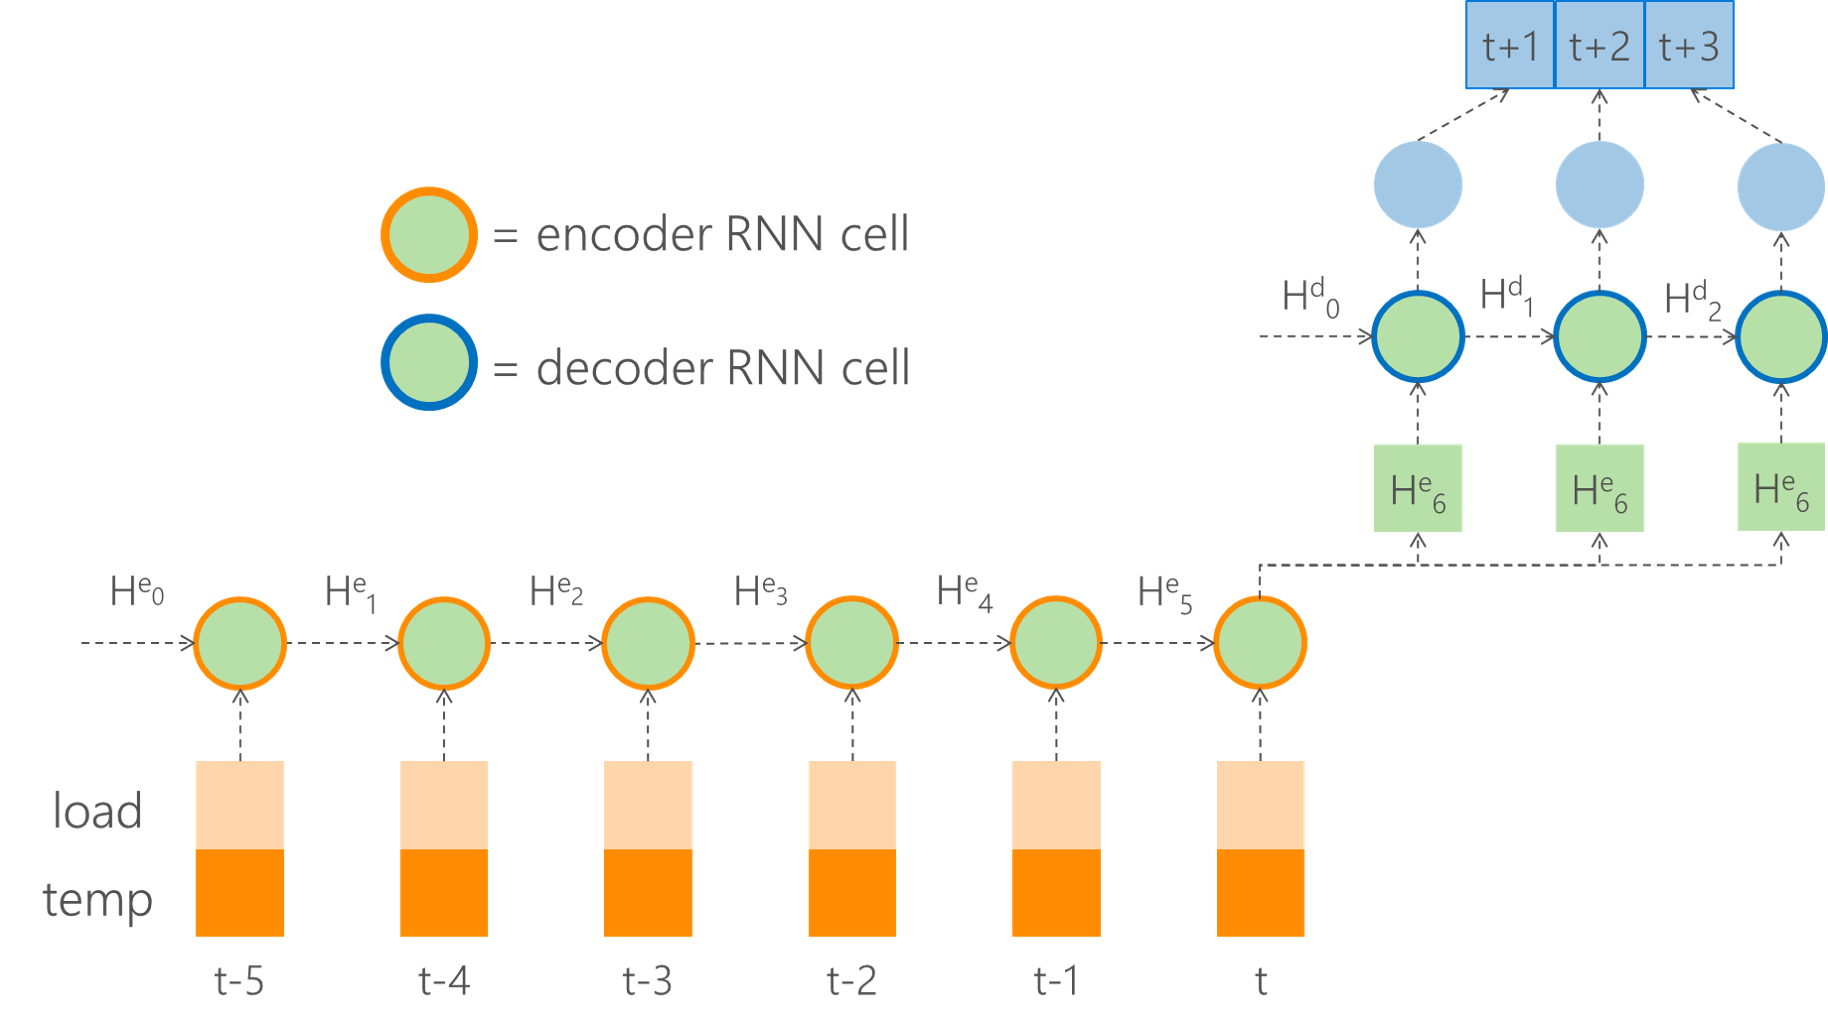

In [12]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

In [13]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [15]:
model.compile(optimizer='RMSprop', loss='mse')

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 5)                   │             135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 3, 5)                │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 1)                │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [18]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Epoch 1/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0295 - val_loss: 0.0071
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 8/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0033 - val_loss: 0.0033


## Evaluate the model

In [19]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [20]:
predictions = model.predict(test_inputs['X'])

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [21]:
predictions

array([[0.23, 0.31, 0.37],
       [0.31, 0.39, 0.45],
       [0.39, 0.46, 0.51],
       ...,
       [0.62, 0.56, 0.5 ],
       [0.57, 0.52, 0.47],
       [0.53, 0.49, 0.44]], dtype=float32)

In [22]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,728.71","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,992.93","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,235.01","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,381.15","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,486.37","3,436.00"


In [23]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

,APE
h,
t+1,0.02
t+2,0.04
t+3,0.06


In [24]:
mape(eval_df['prediction'], eval_df['actual'])

0.04294884908385145

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

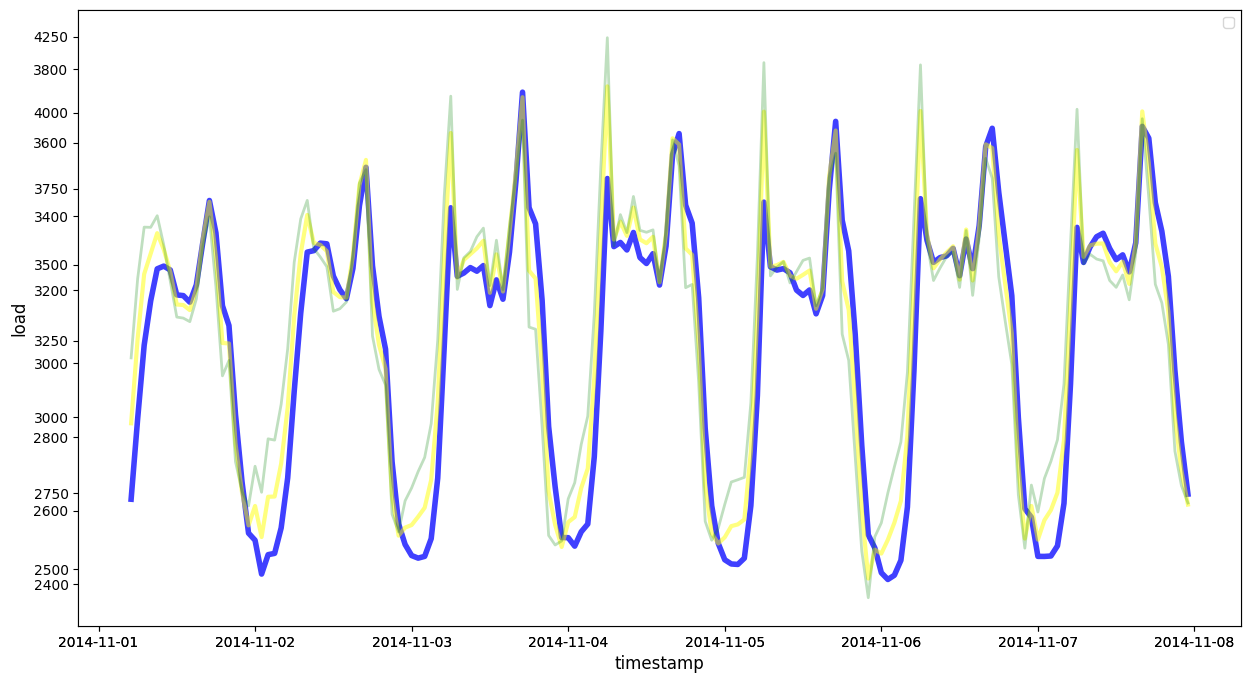

In [27]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='yellow', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='green', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()